In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
# Setting the current working directory
import os; os.chdir('drive/My Drive')

In [4]:
!pwd

/content/drive/My Drive


In [5]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, h5py
import matplotlib.style as style; style.use('fivethirtyeight')
%matplotlib inline

# Metrics and preprocessing
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# TF and Keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

# Checking if GPU is found
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.reset_default_graph()
tf.set_random_seed(42)

Found GPU at: /device:GPU:0


In [9]:
# Read the h5 file
h5_SVH = h5py.File('SVHN_single_grey1.h5', 'r')

In [10]:
# Load the training, validation and test sets
X_train = h5_SVH['X_train'][:]
y_train_o = h5_SVH['y_train'][:]
X_val = h5_SVH['X_val'][:]
y_val_o = h5_SVH['y_val'][:]
X_test = h5_SVH['X_test'][:]
y_test_o = h5_SVH['y_test'][:]

# Close this file

h5_SVH.close()

print('Training set', X_train.shape, y_train_o.shape)
print('Validation set', X_val.shape, y_val_o.shape)
print('Test set', X_test.shape, y_test_o.shape)

print('\n')
print('Unique labels in y_train:', np.unique(y_train_o))
print('Unique labels in y_val:', np.unique(y_val_o))
print('Unique labels in y_test:', np.unique(y_test_o))

Training set (42000, 32, 32) (42000,)
Validation set (60000, 32, 32) (60000,)
Test set (18000, 32, 32) (18000,)


Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_val: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_test: [0 1 2 3 4 5 6 7 8 9]


Length of training sets: 42k, validation sets: 60k, test sets: 18k

Size of the images: 32*32

Number of class: 10

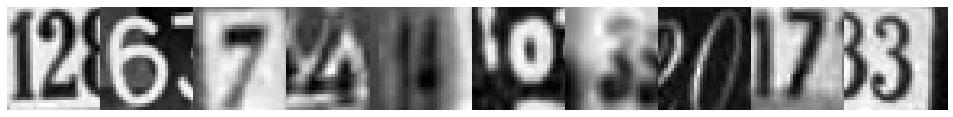

Label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [11]:
# Visualizing first 10 images in the dataset and their labels
plt.figure(figsize = (15, 4.5))
for i in range(10):  
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((32, 32)),cmap = plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace = -0.1, hspace = -0.1)
plt.show()

print('Label for each of the above image: %s' % (y_train_o[0 : 10]))

Checking first image and label in training set
--------------------------------------------------------------------------------


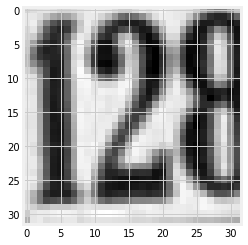

Label: 2


In [12]:
print('Checking first image and label in training set'); print('--'*40)
plt.imshow(X_train[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_train_o[0])

Checking first image and label in validation set
--------------------------------------------------------------------------------


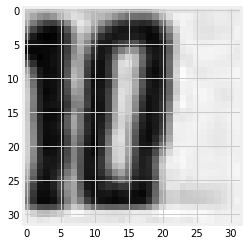

Label: 0


In [13]:

print('Checking first image and label in validation set'); print('--'*40)
plt.imshow(X_val[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_val_o[0])

Checking first image and label in test set
--------------------------------------------------------------------------------


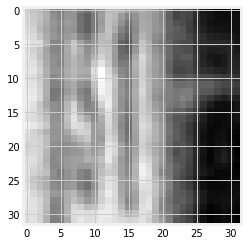

Label: 1


In [14]:
print('Checking first image and label in test set'); print('--'*40)
plt.imshow(X_test[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_test_o[0])

In [15]:
print('Reshaping X data: (n, 32, 32) => (n, 1024)'); print('--'*40)
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

print('Making sure that the values are float so that we can get decimal points after division'); print('--'*40)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('Normalizing the RGB codes by dividing it to the max RGB value'); print('--'*40)
X_train /= 255
X_val /= 255
X_test /= 255

print('Converting y data into categorical (one-hot encoding)'); print('--'*40)
y_train = to_categorical(y_train_o)
y_val = to_categorical(y_val_o)
y_test = to_categorical(y_test_o)

Reshaping X data: (n, 32, 32) => (n, 1024)
--------------------------------------------------------------------------------
Making sure that the values are float so that we can get decimal points after division
--------------------------------------------------------------------------------
Normalizing the RGB codes by dividing it to the max RGB value
--------------------------------------------------------------------------------
Converting y data into categorical (one-hot encoding)
--------------------------------------------------------------------------------


In [16]:

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

print('\n')
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

print('\n')
print('Number of images in X_train', X_train.shape[0])
print('Number of images in X_val', X_val.shape[0])
print('Number of images in X_test', X_test.shape[0])

X_train shape: (42000, 1024)
X_val shape: (60000, 1024)
X_test shape: (18000, 1024)


y_train shape: (42000, 10)
y_val shape: (60000, 10)
y_test shape: (18000, 10)


Number of images in X_train 42000
Number of images in X_val 60000
Number of images in X_test 18000


**Modelling - Baby sitting the learning process**

Fully connected linear layer

In [17]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

ReLu

In [18]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

Softmax function

In [19]:

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

Cross entropy loss

In [20]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

NN class that enables the forward prop and backward propagation of the entire network

In [21]:
class NN():
    def __init__(self, lossfunc = CrossEntropy(), mode = 'train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

Update function SGD with momentum

In [22]:
def update(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = (mu * v[i]) - (learning_rate * g[i])
            p[i] += v[i]

Get minibatches

In [23]:

def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

The training loop

In [24]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu = 0.9, X_val = None, y_val = None, Lambda = 0, verb = True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = []
        y_val_pred = []
        y_train1 = []
        y_vall = []
        for ii in range(0, m_train, minibatch_size):
            X_tr = X_train[ii:ii + minibatch_size, : ]
            y_tr = y_train[ii:ii + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for ii in range(0, m_val, minibatch_size):
            X_va = X_val[ii:ii + minibatch_size, : ]
            y_va = y_val[ii:ii + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)
        
        ## weights
        w = np.array(net.params[0][0])
        
        ## adding regularization to cost
        mean_train_loss = (sum(loss_batch) / float(len(loss_batch)))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        if verb:
            if i%50==0:
                print("Epoch {3}/{4}: Loss = {0} | Training Accuracy = {1}".format(mean_train_loss, train_acc, val_acc, i, epoch))
    return net, val_acc

Checking the accuracy of the model

In [27]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

Invoking all that we have created until now

In [28]:
# Invoking the model
## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb = True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes1 = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes1))

    nn, val_acc = train(nn, X_train, y_train_o, minibatch_size = 200, epoch = iterations, learning_rate = learning_rate,\
                      X_val = X_test, y_val = y_test_o, Lambda = Lambda, verb = verb)
    return val_acc

Double Check that the loss is reasonable : Disable the regularization

In [29]:
lr = 0.00001
Lambda = 0
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 2.308100997350299 | Training Accuracy = 0.10204761904761905


0.10211111111111111

In [30]:
#Now, lets crank up the Lambda(Regularization) and check what it does to our loss function
lr = 0.00001
Lambda = 1e3
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 2.3075877941653418 | Training Accuracy = 0.08861904761904763


0.088

In [31]:
#Now, lets overfit to a small subset of our dataset, in this case 20 images
X_train_subset = X_train[0:20]
y_train_subset = y_train_o[0:20]

X_train = X_train_subset
y_train_o = y_train_subset

X_train.shape, y_train_o.shape

((20, 1024), (20,))

**Make sure that you can overfit very small portion of the training data**

So, set a small learning rate and turn regularization off In the code below:

Take the first 20 examples

turn off regularization(reg=0.0)

use simple vanilla 'sgd'


In [32]:

%time
lr = 0.001
Lambda = 0
train_and_test_loop(5000, lr, Lambda)

CPU times: user 10 µs, sys: 3 µs, total: 13 µs
Wall time: 16.5 µs
Epoch 0/5000: Loss = 2.2491220477822242 | Training Accuracy = 0.15
Epoch 50/5000: Loss = 1.9277344219372892 | Training Accuracy = 0.3
Epoch 100/5000: Loss = 1.8486931782576068 | Training Accuracy = 0.45
Epoch 150/5000: Loss = 1.7964648373112488 | Training Accuracy = 0.45
Epoch 200/5000: Loss = 1.7525596845358264 | Training Accuracy = 0.5
Epoch 250/5000: Loss = 1.7128033896444967 | Training Accuracy = 0.5
Epoch 300/5000: Loss = 1.6757047123659192 | Training Accuracy = 0.5
Epoch 350/5000: Loss = 1.6405821520239208 | Training Accuracy = 0.5
Epoch 400/5000: Loss = 1.6070708285799742 | Training Accuracy = 0.5
Epoch 450/5000: Loss = 1.5749500302705703 | Training Accuracy = 0.55
Epoch 500/5000: Loss = 1.5440718124932777 | Training Accuracy = 0.55
Epoch 550/5000: Loss = 1.51432817913074 | Training Accuracy = 0.55
Epoch 600/5000: Loss = 1.4856348027691766 | Training Accuracy = 0.55
Epoch 650/5000: Loss = 1.4579224112512952 | Trai

0.13727777777777778

In [33]:
#Loading the original dataset again
h5_SVH = h5py.File('SVHN_single_grey1.h5', 'r')
# Load the training, validation and test sets
X_train = h5_SVH['X_train'][:]
y_train_o = h5_SVH['y_train'][:]
X_val = h5_SVH['X_val'][:]
y_val_o = h5_SVH['y_val'][:]
X_test = h5_SVH['X_test'][:]
y_test_o = h5_SVH['y_test'][:]

print('Reshaping X data: (n, 32, 32) => (n, 1024)'); print('--'*40)
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

print('Making sure that the values are float so that we can get decimal points after division'); print('--'*40)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('Normalizing the RGB codes by dividing it to the max RGB value'); print('--'*40)
X_train /= 255
X_val /= 255
X_test /= 255

print('Converting y data into categorical (one-hot encoding)'); print('--'*40)
y_train = to_categorical(y_train_o)
y_val = to_categorical(y_val_o)
y_test = to_categorical(y_test_o)

Reshaping X data: (n, 32, 32) => (n, 1024)
--------------------------------------------------------------------------------
Making sure that the values are float so that we can get decimal points after division
--------------------------------------------------------------------------------
Normalizing the RGB codes by dividing it to the max RGB value
--------------------------------------------------------------------------------
Converting y data into categorical (one-hot encoding)
--------------------------------------------------------------------------------


**Start with small regularization and find learning rate that makes the loss go down.**

we start with Lambda(small regularization) = 1e-7

we start with a small learning rate = 1e-7

In [34]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.3181051126974146 | Training Accuracy = 0.09907142857142857
Epoch 50/500: Loss = 2.3127125997827465 | Training Accuracy = 0.09971428571428571
Epoch 100/500: Loss = 2.309285909940037 | Training Accuracy = 0.10042857142857142
Epoch 150/500: Loss = 2.307092680058417 | Training Accuracy = 0.1005952380952381
Epoch 200/500: Loss = 2.3056812738828394 | Training Accuracy = 0.09988095238095238
Epoch 250/500: Loss = 2.304768511881174 | Training Accuracy = 0.10002380952380953
Epoch 300/500: Loss = 2.304174970415249 | Training Accuracy = 0.10042857142857142
Epoch 350/500: Loss = 2.303786237292737 | Training Accuracy = 0.10057142857142858
Epoch 400/500: Loss = 2.3035290794478227 | Training Accuracy = 0.10121428571428571
Epoch 450/500: Loss = 2.3033565199716186 | Training Accuracy = 0.09964285714285714


0.09694444444444444

In [35]:
#Lets try to train now with a value of learning rate 0.001
lr = 0.001
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.3038100947086106 | Training Accuracy = 0.1153095238095238
Epoch 50/500: Loss = 2.259406173835449 | Training Accuracy = 0.21007142857142858
Epoch 100/500: Loss = 2.2508995120932145 | Training Accuracy = 0.2200952380952381
Epoch 150/500: Loss = 2.2465671740634754 | Training Accuracy = 0.22492857142857142
Epoch 200/500: Loss = 2.243668694501525 | Training Accuracy = 0.22814285714285715
Epoch 250/500: Loss = 2.2414897320526572 | Training Accuracy = 0.22997619047619047
Epoch 300/500: Loss = 2.2397439602973037 | Training Accuracy = 0.23202380952380952
Epoch 350/500: Loss = 2.2382871909748627 | Training Accuracy = 0.23347619047619048
Epoch 400/500: Loss = 2.23703639958682 | Training Accuracy = 0.2344047619047619
Epoch 450/500: Loss = 2.235939445644749 | Training Accuracy = 0.2349047619047619


0.21761111111111112

In [36]:
#Hyperparameter Optimization
#Running a finer search

import math
for k in range(1, 10):
    lr = math.pow(10, np.random.uniform(-3.0, -2.0))
    Lambda = math.pow(10, np.random.uniform(-5, 2))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 10, best_acc, lr, Lambda))

Try 1/10: Best_val_acc: 0.20583333333333334, lr: 0.0014332136596590015, Lambda: 44.836407072910625

Try 2/10: Best_val_acc: 0.21072222222222223, lr: 0.0030645369744048798, Lambda: 0.0038038543177265145

Try 3/10: Best_val_acc: 0.201, lr: 0.005376211909501392, Lambda: 0.02027346854920309

Try 4/10: Best_val_acc: 0.19727777777777777, lr: 0.00209363338437974, Lambda: 1.2552896839937797e-05

Try 5/10: Best_val_acc: 0.20544444444444446, lr: 0.003571592523572499, Lambda: 2.546926938149572

Try 6/10: Best_val_acc: 0.2117777777777778, lr: 0.004606049015880646, Lambda: 7.517921432676577

Try 7/10: Best_val_acc: 0.1768888888888889, lr: 0.006781639317306768, Lambda: 0.990019122986644

Try 8/10: Best_val_acc: 0.20972222222222223, lr: 0.0033636109526767838, Lambda: 3.6534048637752225e-05

Try 9/10: Best_val_acc: 0.19927777777777778, lr: 0.0013247707565504797, Lambda: 0.001608111253858637



**NN model, sigmoid activations, SGD optimizer**

In [37]:

print('NN model with sigmoid activations'); print('--'*40)
# Initialize the neural network classifier
model1 = Sequential()

# Input Layer - adding input layer and activation functions sigmoid
model1.add(Dense(128, input_shape = (1024, )))
# Adding activation function
model1.add(Activation('sigmoid'))

#Hidden Layer 1 - adding first hidden layer
model1.add(Dense(64))
# Adding activation function
model1.add(Activation('sigmoid'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model1.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model1.add(Activation('softmax'))

NN model with sigmoid activations
--------------------------------------------------------------------------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [38]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 140,106
Trainable params: 140,106
Non-trainable params: 0
__________________________________________________

In [39]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model1.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model1.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 3s 70us/sample - loss: 2.3173 - acc: 0.1009 - val_loss: 2.3030 - val_acc: 0.1002
Epoch 2/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.3031 - acc: 0.0986 - val_loss: 2.3028 - val_acc: 0.0959
Epoch 3/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.3030 - acc: 0.1001 - val_loss: 2.3028 - val_acc: 0.1031
Epoch 4/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.3029 - acc: 0.1012 - val_loss: 2.3028 - val_acc: 0.0992
Epoch 5/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.3029 - acc: 0.1006 - val_loss: 2.3027 - val_acc: 0.1048
Epoch 6/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.3029 - acc: 0.0997 - val_loss: 2.3027 - val_acc: 0.0992
Epoch 7/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.3028 - acc: 0.1000 - val_l

In [40]:
print('Evaluate NN model with sigmoid activations'); print('--'*40)
results1 = model1.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results1[1]*100, 2), '%'))

Evaluate NN model with sigmoid activations
--------------------------------------------------------------------------------
60000/60000 [==============================] - 3s 53us/sample - loss: 2.2992 - acc: 0.1300
Validation accuracy: 13.0


In [41]:

print('NN model with sigmoid activations - changing learning rate'); print('--'*40)
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.001)
model1.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model1.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

NN model with sigmoid activations - changing learning rate
--------------------------------------------------------------------------------
Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 1s 32us/sample - loss: 2.2990 - acc: 0.1326 - val_loss: 2.2992 - val_acc: 0.1298
Epoch 2/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.2990 - acc: 0.1302 - val_loss: 2.2992 - val_acc: 0.1291
Epoch 3/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.2990 - acc: 0.1314 - val_loss: 2.2992 - val_acc: 0.1290
Epoch 4/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.2990 - acc: 0.1275 - val_loss: 2.2991 - val_acc: 0.1290
Epoch 5/100
42000/42000 [==============================] - 1s 31us/sample - loss: 2.2990 - acc: 0.1299 - val_loss: 2.2991 - val_acc: 0.1297
Epoch 6/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.2990 - acc: 0.1312 - val_l

In [42]:
print('Evaluate NN model with sigmoid activations - changing learning rate'); print('--'*40)
results1 = model1.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results1[1]*100, 2), '%'))

Evaluate NN model with sigmoid activations - changing learning rate
--------------------------------------------------------------------------------
60000/60000 [==============================] - 3s 53us/sample - loss: 2.2988 - acc: 0.1306
Validation accuracy: 13.06


**NN model, relu activations**

In [43]:
%time
print('NN model with relu activations and sgd optimizers'); print('--'*40)
# Initialize the neural network classifier
model2 = Sequential()

# Input Layer - adding input layer and activation functions relu
model2.add(Dense(128, input_shape = (1024, )))
# Adding activation function
model2.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model2.add(Dense(64))
# Adding activation function
model2.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model2.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model2.add(Activation('softmax'))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
NN model with relu activations and sgd optimizers
--------------------------------------------------------------------------------


In [44]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               131200    
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 140,106
Trainable params: 140,106
Non-trainable params: 0
________________________________________________

In [45]:

# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model2.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 1s 32us/sample - loss: 2.3000 - acc: 0.1174 - val_loss: 2.2903 - val_acc: 0.1333
Epoch 2/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.2851 - acc: 0.1473 - val_loss: 2.2800 - val_acc: 0.1515
Epoch 3/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.2715 - acc: 0.1764 - val_loss: 2.2644 - val_acc: 0.1867
Epoch 4/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.2562 - acc: 0.2118 - val_loss: 2.2469 - val_acc: 0.2315
Epoch 5/100
42000/42000 [==============================] - 1s 29us/sample - loss: 2.2374 - acc: 0.2501 - val_loss: 2.2261 - val_acc: 0.2683
Epoch 6/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.2141 - acc: 0.2830 - val_loss: 2.1991 - val_acc: 0.3007
Epoch 7/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.1848 - acc: 0.3144 - val_l

In [46]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
60000/60000 [==============================] - 3s 53us/sample - loss: 0.7320 - acc: 0.7849
Validation accuracy: 78.49


In [47]:
%time
print('NN model with relu activations and sgd optimizers - changing learning rate'); print('--'*40)
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.001)
model2.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
NN model with relu activations and sgd optimizers - changing learning rate
--------------------------------------------------------------------------------
Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 1s 32us/sample - loss: 0.6815 - acc: 0.8010 - val_loss: 0.7018 - val_acc: 0.7960
Epoch 2/100
42000/42000 [==============================] - 1s 31us/sample - loss: 0.6788 - acc: 0.8014 - val_loss: 0.7011 - val_acc: 0.7959
Epoch 3/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.6787 - acc: 0.8015 - val_loss: 0.7001 - val_acc: 0.7961
Epoch 4/100
42000/42000 [==============================] - 1s 31us/sample - loss: 0.6780 - acc: 0.8025 - val_loss: 0.7005 - val_acc: 0.7962
Epoch 5/100
42000/42000 [==============================] - 1s 31us/sample - loss: 0.6778 - acc: 0.8022 - val_loss: 0.6997 - val_acc: 0.7964
Epoch 6/100
42000/42000 [=====

In [48]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
60000/60000 [==============================] - 3s 53us/sample - loss: 0.6708 - acc: 0.8049
Validation accuracy: 80.49


In [49]:
%time
print('NN model with relu activations and adam optimizer'); print('--'*40)
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.01)
model2.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
NN model with relu activations and adam optimizer
--------------------------------------------------------------------------------
Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 1s 34us/sample - loss: 3.0436 - acc: 0.1231 - val_loss: 2.2302 - val_acc: 0.1424
Epoch 2/100
42000/42000 [==============================] - 1s 31us/sample - loss: 2.1184 - acc: 0.1864 - val_loss: 2.0724 - val_acc: 0.2036
Epoch 3/100
42000/42000 [==============================] - 1s 31us/sample - loss: 2.0230 - acc: 0.2262 - val_loss: 1.9843 - val_acc: 0.2479
Epoch 4/100
42000/42000 [==============================] - 1s 31us/sample - loss: 2.0024 - acc: 0.2386 - val_loss: 1.9564 - val_acc: 0.2605
Epoch 5/100
42000/42000 [==============================] - 1s 31us/sample - loss: 1.9699 - acc: 0.2533 - val_loss: 1.9342 - val_acc: 0.2728
Epoch 6/100
42000/42000 [==============================

In [50]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
60000/60000 [==============================] - 3s 54us/sample - loss: 1.3817 - acc: 0.5420
Validation accuracy: 54.2


In [51]:
%time
print('NN model with relu activations and adam optimizer'); print('--'*40)
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model2.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
NN model with relu activations and adam optimizer
--------------------------------------------------------------------------------
Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 1s 34us/sample - loss: 1.3544 - acc: 0.5510 - val_loss: 1.3527 - val_acc: 0.5520
Epoch 2/100
42000/42000 [==============================] - 1s 31us/sample - loss: 1.3513 - acc: 0.5515 - val_loss: 1.3503 - val_acc: 0.5526
Epoch 3/100
42000/42000 [==============================] - 1s 31us/sample - loss: 1.3492 - acc: 0.5531 - val_loss: 1.3490 - val_acc: 0.5528
Epoch 4/100
42000/42000 [==============================] - 1s 31us/sample - loss: 1.3480 - acc: 0.5526 - val_loss: 1.3485 - val_acc: 0.5535
Epoch 5/100
42000/42000 [==============================] - 1s 31us/sample - loss: 1.3483 - acc: 0.5524 - val_loss: 1.3532 - val_acc: 0.5511
Epoch 6/100
42000/42000 [==============================

In [52]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
60000/60000 [==============================] - 3s 55us/sample - loss: 1.3384 - acc: 0.5584
Validation accuracy: 55.84


**Observation - NN model with relu activations**

- Improves the scores considerably compared to Sigmoid activations.

- Best accuracy achieved till now is using relu activations, SGD optimizer (above Adam optimizer), changing learning rate to 0.001



**Prediction on test dataset using relu activations, Adam optimizers**

In [53]:
# Initialize the neural network classifier
model3 = Sequential()

# Input Layer - adding input layer and activation functions relu
model3.add(Dense(256, input_shape = (1024, )))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model3.add(Dense(128))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 2 - Adding second hidden layer
model3.add(Dense(64))
# Adding activation function
model3.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model3.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model3.add(Activation('softmax'))

In [54]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model3.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 2s 37us/sample - loss: 2.2835 - acc: 0.1350 - val_loss: 2.1228 - val_acc: 0.2428
Epoch 2/100
42000/42000 [==============================] - 1s 34us/sample - loss: 1.7629 - acc: 0.3865 - val_loss: 1.4984 - val_acc: 0.4983
Epoch 3/100
42000/42000 [==============================] - 1s 34us/sample - loss: 1.3719 - acc: 0.5508 - val_loss: 1.2253 - val_acc: 0.6167
Epoch 4/100
42000/42000 [==============================] - 1s 34us/sample - loss: 1.2032 - acc: 0.6195 - val_loss: 1.1142 - val_acc: 0.6461
Epoch 5/100
42000/42000 [==============================] - 1s 33us/sample - loss: 1.1020 - acc: 0.6560 - val_loss: 1.1006 - val_acc: 0.6554
Epoch 6/100
42000/42000 [==============================] - 1s 33us/sample - loss: 1.0085 - acc: 0.6914 - val_loss: 0.9612 - val_acc: 0.7051
Epoch 7/100
42000/42000 [==============================] - 1s 34us/sample - loss: 0.9561 - acc: 0.7057 - val_l

In [55]:

print('NN with batch normalization'); print('--'*40)
results3 = model3.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results3[1]*100, 2), '%'))

NN with batch normalization
--------------------------------------------------------------------------------
60000/60000 [==============================] - 3s 58us/sample - loss: 0.4284 - acc: 0.8768
Validation accuracy: 87.68


In [56]:
print('Testing the model on test dataset')
predictions = model3.predict_classes(X_test)
score = model3.evaluate(X_test, y_test)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Testing the model on test dataset
18000/18000 [==============================] - 1s 57us/sample - loss: 0.6978 - acc: 0.8243
Test loss : 0.6978000909752315
Test accuracy : 0.82427776


In [57]:
print('Classification Report'); print('--'*40)
print(classification_report(y_test_o, predictions))

Classification Report
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1814
           1       0.77      0.87      0.82      1828
           2       0.83      0.85      0.84      1803
           3       0.82      0.77      0.79      1719
           4       0.82      0.89      0.85      1812
           5       0.81      0.81      0.81      1768
           6       0.87      0.77      0.82      1832
           7       0.84      0.88      0.86      1808
           8       0.79      0.76      0.78      1812
           9       0.81      0.81      0.81      1804

    accuracy                           0.82     18000
   macro avg       0.83      0.82      0.82     18000
weighted avg       0.83      0.82      0.82     18000



Visualizing the confusion matrix


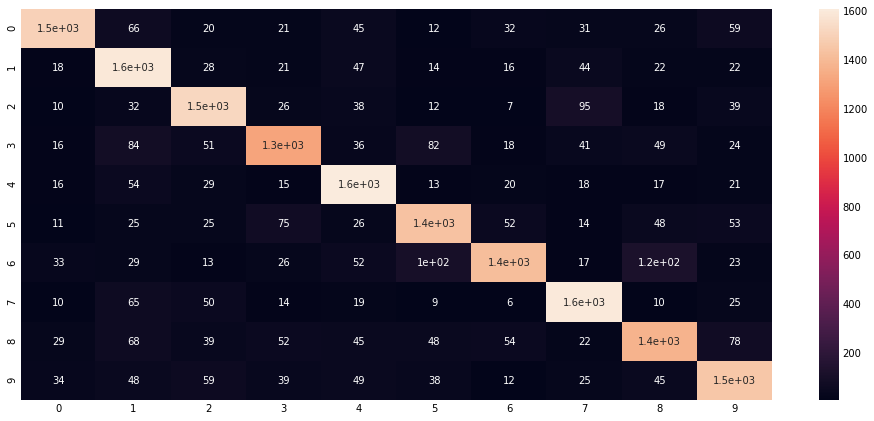

In [58]:
print('Visualizing the confusion matrix')
plt.figure(figsize = (15, 7.2))
sns.heatmap(confusion_matrix(y_test_o, predictions), annot = True)

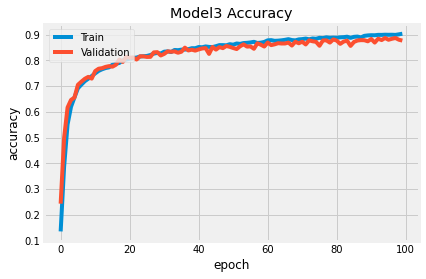

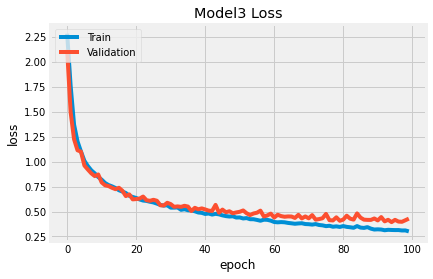

In [59]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model3 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

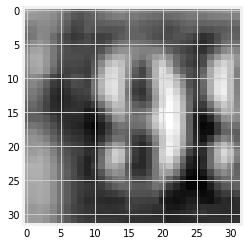

In [66]:
plt.imshow(X_test[5].reshape(32, 32), cmap = 'gray')


In [67]:
model3.predict_classes(X_test)[5]

9

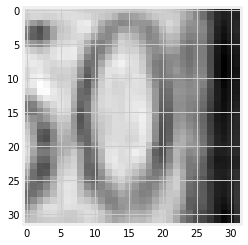

In [61]:
#Showing the image
plt.imshow(X_test[20].reshape(32, 32), cmap = 'gray')

In [63]:
model3.predict_classes(X_test)[20]

0

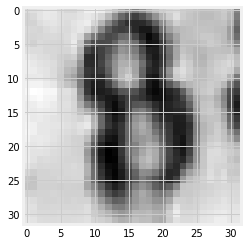

In [64]:
plt.imshow(X_test[10].reshape(32, 32), cmap = 'gray')

In [65]:
model3.predict_classes(X_test)[10]

8